In [1]:
# import necessary modules
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
import pickle

# Landscape Plotting Functions

In [2]:
"""
organizes run iteration data into 3 lists: 2 traits + 1 variable specific to the function
- score/drop functions gather final values
- population zone functions gather average positional data from a latter portion of model runs
"""

def pull_data(master_data,z_pos):
    dps = []
    pps = []
    z_variable = []
    for data in master_data:
        dps.append(data[0])
        pps.append(data[1])
        z_variable.append(data[z_pos][-1])
    return dps, pps, z_variable

def pull_data_ss(master_data,z_pos,ss_step_num):
    dps = []
    pps = []
    z_variable = []
    for data in master_data:
        dps.append(data[0])
        pps.append(data[1])
        z_variable.append(np.average(data[z_pos][ss_step_num:]))
    return dps, pps, z_variable 

def pull_data_ss_foragenest_gap(master_data,ss_step_num):
    dps = []
    pps = []
    z_variable = []
    for dp, pp, c_score, g_score, t_score, drops, nest_zone, forage_zone, tree_zone in master_data:
        dps.append(dp)
        pps.append(pp)
        z_variable.append(np.average(forage_zone[ss_step_num:])-np.average(nest_zone[ss_step_num:]))
    return dps, pps, z_variable 

In [3]:
def interpolate(data_input, interpolation_function='linear'):
    """
    Transforms raw iterated simulation data into condensed data structure
    Maps interpolated scores onto dense mesh grid of traits (dp x pp)
    
    Interpolation functions :
    
    'linear': r
    'cubic': r**3
    'quintic': r**5
    'thin_plate': r**2 * log(r)
    'gaussian': exp(-(r/self.epsilon)**2)
    'inverse': 1.0/sqrt((r/self.epsilon)**2 + 1)
    'multiquadric': sqrt((r/self.epsilon)**2 + 1)
    """
    # unpack data
    dps, pps, z_variable = data_input
    
    # convert into dictionary
    data_dict = {'drop_prob':dps, 
            'pickup_prob':pps, 
            'z_variable':z_variable}
    
    # output as 2D data structure via pandas DataFrame  
    df = pd.DataFrame(data_dict) 
    
    # align the repeated runs with same (dp x pp) + condense by averaging the scores
    means = df.groupby(['drop_prob', 'pickup_prob'], as_index=False)['z_variable'].mean()
    
    # set each data column to different axes
    x = means['pickup_prob']
    y = means['drop_prob']
    z = means['z_variable']
    
    # create mesh grid to map interpolation onto
    xi, yi = np.linspace(x.min(), x.max(), 101), np.linspace(y.min(), y.max(), 101)
    xi, yi = np.meshgrid(xi, yi)
    
    # interpolate the input dp x pp x score data
    rbf = scipy.interpolate.Rbf(x, y, z, function=interpolation_function)
    
    # map interpolation onto the mesh grid, creates a new estimated score for each grid position
    zi = rbf(xi, yi)
    
    return xi, yi, zi

In [4]:
def gradient_arrow_heatmap(interpolated_data, max_min, title, z_min=0, z_max=0,
                   normalize=True, vanishing_arrows=True, arrow_size=.5):
    """
    Calculates a mesh of arrows which shows direction and/or strength of gradient 
        along interpolated trait-score landscape
    Plots heatmap along with mesh with key design parameters:
    - normalize:
        - TRUE: arrows show direction only, gradient strength (arrow length) is equalized
    - vanishing_arrows:
        - TRUE: arrows with low gradient strength are displayed as dots
        - FALSE: arrows with low gradient strength are displayed as arrow heads
    """
    # unpacks interpolated output of interpolate()
    xi,yi,zi = interpolated_data
    
    # origins of arrows set to every 5 trait values in the middle of the grid (excluding 0, 100)
    a_min, a_max, a_stepsize = 5, 96, 5
    
    # discretizes interpolated data according to arrow origins
    xia = xi[a_min:a_max:a_stepsize, a_min:a_max:a_stepsize]
    yia = yi[a_min:a_max:a_stepsize, a_min:a_max:a_stepsize]
    zia = zi[a_min:a_max:a_stepsize, a_min:a_max:a_stepsize]
    
    # finds gradient of the interpolated score arrow matrix
    yig, xig = np.gradient(zia)
    
    # plot background heatmap from interpolated data
    plot_heatmap(interpolated_data, max_min, title, z_min, z_max)
    
    # decision hierarchy which decides plot design
    # normalizing disregards gradient strength >> arrows are same length + only show direction
    # vanishing_arrows uses quiver() >> minimum length arrows plot as dots
    # non-vanishing_arrows uses arrow() + vectorize() >> minimum length arrows plot as arrow heads
    
    if normalize == True:
        dx = xig / np.sqrt(xig**2 + yig**2)
        dy = yig / np.sqrt(xig**2 + yig**2)
        
        plt.quiver(xia, yia, dx, dy, headwidth=5, headlength=5)
            
    else: # normalize: False
        dx, dy = xig, yig
        
        if vanishing_arrows == True:
            plt.quiver(xia, yia, dx, dy, headwidth=5, headlength=5)
        else: # vanishing_arrows: False
            vectorized_arrow_drawing = np.vectorize(func_to_vectorize)
            vectorized_arrow_drawing(xia, yia, dx, dy, 0.01 * arrow_size)

    plt.show()
    
def plot_heatmap(interpolated_data, max_min, title, z_min, z_max, cmap=plt.cm.gist_rainbow):
    """
    Plots heatmap of interpolated trait-score data
    Called within gradient_arrow_heatmap()
    """
    # unpacks interpolated output of interpolate()
    xi,yi,zi = interpolated_data
    
    # if no max score is defined, uses the maximum interpolated value rounded to the nearest hundred
    if z_max == 0:
        z_max = round(np.max(zi)/100)*100
    
    # sets up figure
    _, ax = plt.subplots(figsize=(10, 10))
    ax.set_title(title)
    ax.set_xlabel('Pickup Probability', fontsize=12)
    ax.set_ylabel('Drop Probability', fontsize=12)
    
    # plots heatmap according to color scheme, bounded in the x/y/z directions
    hm = ax.imshow(zi, interpolation='none', cmap=cmap,
                extent=[xi.min(), xi.max(), yi.min(), yi.max()], origin=[0,0],
                vmin=z_min, vmax=z_max) 
    
    # adds color bar to the right side of heatmap
    cbar = plt.colorbar(hm)
    
    if max_min != 0:
        # pull max + min data
        dp_max, pp_max, z_max, dp_min, pp_min, z_min = max_min

        plt.plot(pp_max,dp_max,'ro')
        plt.plot(pp_min,dp_min,'bo')
        
def func_to_vectorize(x, y, dx, dy, scaling):
    """
    Used for plotting gradient arrows in conjunction with vectorize()
    Called within gradient_arrow_heatmap()
    """
    plt.arrow(x, y, dx*scaling, dy*scaling, fc="k", ec="k", head_width=1.5, head_length=1)

In [5]:
def linear_cost(data_nocost, max_cost, apply_pp_cost=True, apply_dp_cost=True, plot_cost=False):
    """
    Scales score by relative trait values of either/or dp + pp, bounded by max_cost
    Output mirrors the pull_data functions (3 lists)
    """
    dps = []
    pps = []
    scaled_scores = []
    for dp, pp, c_score, g_score, t_score, drops, nest_zone, forage_zone, tree_zone in data_nocost:
        pp_cost = pp/100 * max_cost * apply_pp_cost
        dp_cost = dp/100 * max_cost * apply_dp_cost
        # score proportionally decreased by higher pp and/or dp trait values
        scaled_score = t_score[-1]*(1 - pp_cost - dp_cost)
        # builds lists
        dps.append(dp)
        pps.append(pp)
        scaled_scores.append(scaled_score)
    
    # plots cost function if called
    if plot_cost == True:
        x = np.linspace(0, 100, 101)
        y = x/100 * max_cost
        fig = plt.figure(figsize = (10, 5))
        plt.plot(x, y)
    
    return dps, pps, scaled_scores

In [6]:
def find_max_min(data, print_max=False, print_min=False):
    """
    Finds the max/min of a z_variable list, outputs this along with corresponding trait values
    """
    dps, pps, z_variables = data
    
    z_max = max(z_variables)
    index_max = z_variables.index(z_max)
    
    dp_max = dps[index_max]
    pp_max = pps[index_max]
    
    z_min = min(z_variables)
    index_min = z_variables.index(z_min)
    
    dp_min = dps[index_min]
    pp_min = pps[index_min]
    
    if print_max == True:
        print(f'pp_max: {round(pp_max,1)}, dp_max: {round(dp_max,1)}, z_max: {round(z_max,1)}')
    if print_min == True:
        print(f'pp_min: {round(pp_min,1)}, dp_min: {round(dp_min,1)}, z_min: {round(z_min,1)}')
    
    return dp_max, pp_max, z_max, dp_min, pp_min, z_min

# Plotting Final Total Score Landscapes

pp_max: 100, dp_max: 100, z_max: 866.3


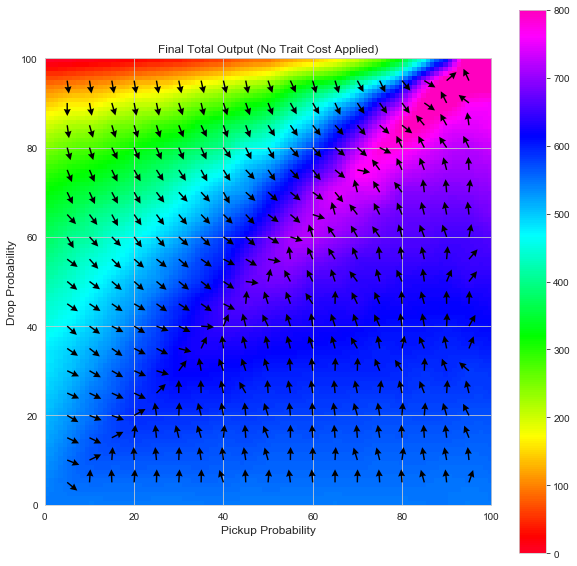

pp_max: 90, dp_max: 95, z_max: 624.3


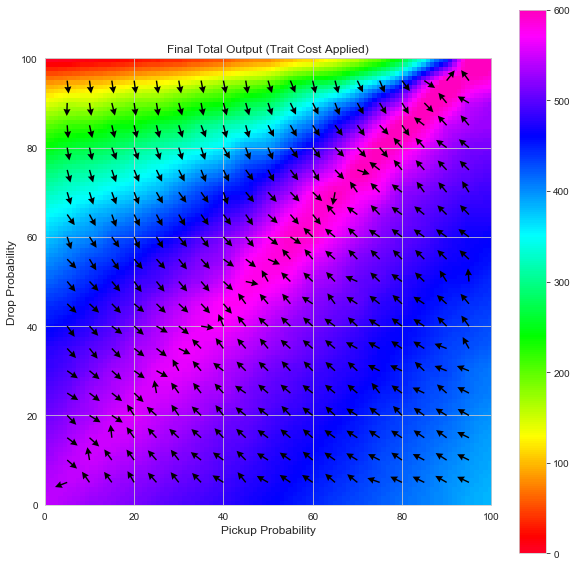

In [7]:
"""
plots heatmap landscapes using final total score data gathered in the ABM notebook file
both as raw data + after a trait behavioral adaptation cost has been applied 
- Trait Cost linearly scales with increasing pickup_probability
    - drop_probability already has 'cost' built in for high adaptation levels:
    ants can ignore dropped leaves, wasting the effort of the dropper
    - pickup_probability cost is where an ant would waste time looking for dropped leaves,
    e.g. wander, pick up non-leaf objects (behaviors not included in the simulation)
"""

# save filename to use in plot title + load landscape data
title = 'landscape_data_dplen10_ant25_spacing5_rep10_step1K'
master_data = pickle.load(open(title,'rb'))

# extract final total score data for each trait combination (drop + pickup probabilities)
data_nocost = pull_data(master_data,4)
# find the maximum + minimum final trait score + associated trait combinations, print the maximum
max_min = find_max_min(data_nocost, print_max=True)
# interpolate between the data points to create dense data mesh for plotting
interp_data_nocost = interpolate(data_nocost, 'linear')
# plot heatmap with arrows to signify the gradient at equally spaced points throughout plot
gradient_arrow_heatmap(interp_data_nocost, max_min=0, 
    title=f'Final Total Output (No Trait Cost Applied)',
    z_max=800, normalize=True, vanishing_arrows=True, arrow_size=.5)

# apply a cost that linearly scales with increasing pickup_probability 
# output data is in the same form as pull_data_final_tscore
data_cost = linear_cost(master_data, 0.3, apply_pp_cost=True, apply_dp_cost=False, plot_cost=False)
max_min = find_max_min(data_cost, print_max=True)
interp_data_cost = interpolate(data_cost, 'linear')
gradient_arrow_heatmap(interp_data_cost, max_min=0, 
    title=f'Final Total Output (Trait Cost Applied)', 
    z_max=600, normalize=True, vanishing_arrows=True, arrow_size=.5)

# Plotting Final Specific Output Landscapes

pp_max: 100, dp_max: 100, z_max: 866.3


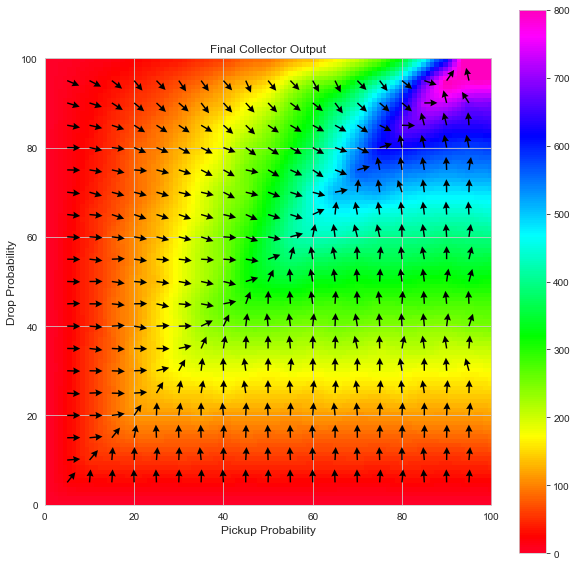

pp_max: 90, dp_max: 0, z_max: 547.3


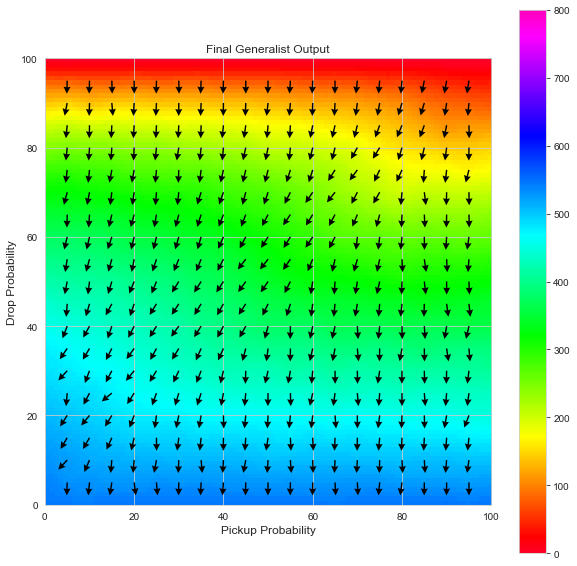

pp_max: 0, dp_max: 100, z_max: 1880.0


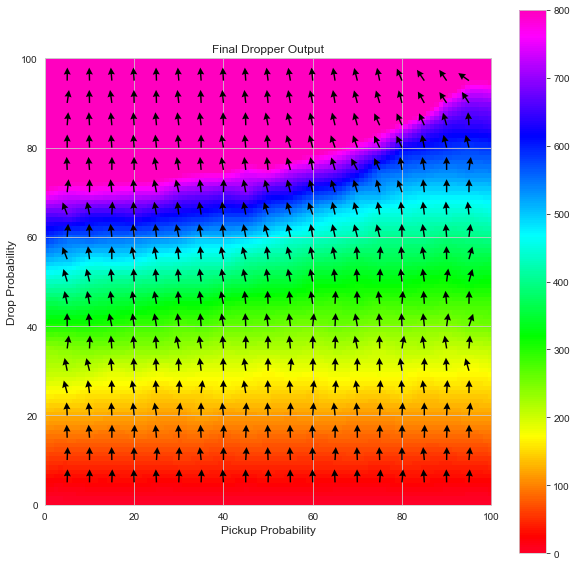

In [8]:
"""
plots heatmap landscapes using final specific output data gathered in the ABM notebook file
- Final Collector Output : number of leaves gathered by ants from the bottom of the tree
- Final Generalist Output : number of leaves gathered by ants from the top of the tree
- Final Dropper Output : number of leaves dropped (from the top of the tree)
"""

title = 'landscape_data_dplen10_ant25_spacing5_rep10_step1K'
master_data = pickle.load(open(title,'rb'))

# maximum score value (z-variable in heatmap) for each landscape
plot_max = 800

data = pull_data(master_data,2)
max_min = find_max_min(data, print_max=True)
interp_data = interpolate(data, 'linear')
gradient_arrow_heatmap(interp_data, max_min=0, title=f'Final Collector Output',
    z_max=plot_max, normalize=True, vanishing_arrows=True, arrow_size=.5)

data = pull_data(master_data,3)
max_min = find_max_min(data, print_max=True)
interp_data = interpolate(data, 'linear')
gradient_arrow_heatmap(interp_data, max_min=0, title=f'Final Generalist Output',
    z_max=plot_max, normalize=True, vanishing_arrows=True, arrow_size=.5)

data = pull_data(master_data,5)
max_min = find_max_min(data, print_max=True)
interp_data = interpolate(data, 'linear')
gradient_arrow_heatmap(interp_data, max_min=0, title=f'Final Dropper Output',
    z_max=plot_max, normalize=True, vanishing_arrows=True, arrow_size=.5)

# Plotting Population Zone Landscapes

pp_max: 5, dp_max: 100, z_max: 22.9
pp_min: 90, dp_min: 0, z_min: 6.6


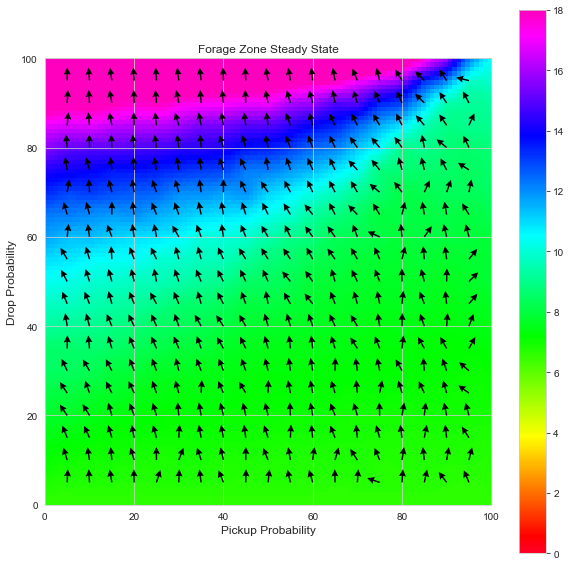

pp_max: 50, dp_max: 0, z_max: 11.3
pp_min: 95, dp_min: 100, z_min: 1.2


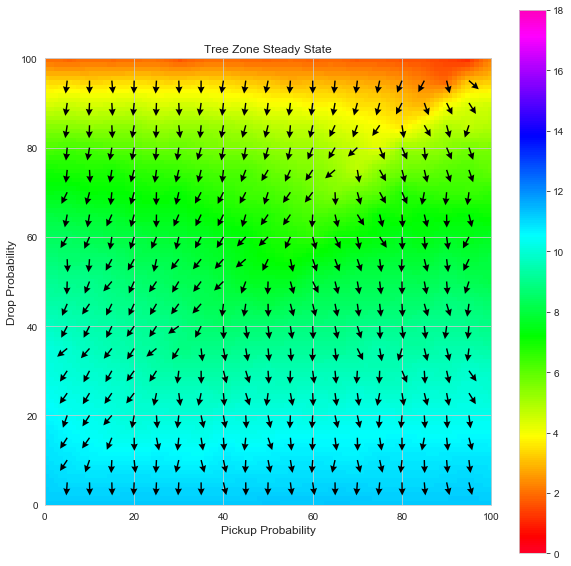

pp_max: 100, dp_max: 100, z_max: 12.3
pp_min: 0, dp_min: 100, z_min: 0.1


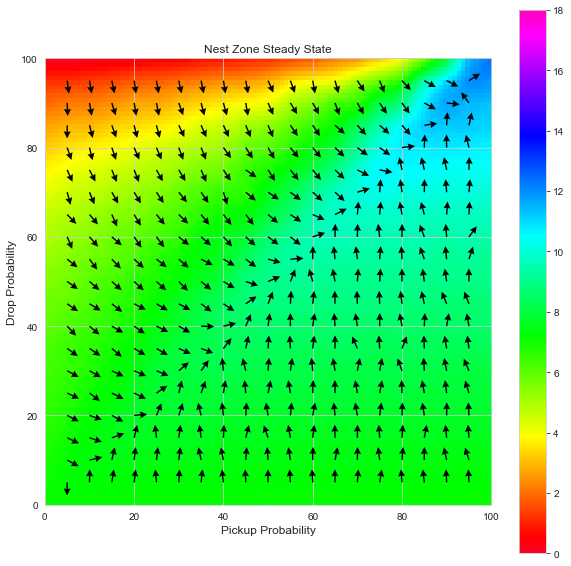

pp_max: 0, dp_max: 100, z_max: 22.8
pp_min: 90, dp_min: 90, z_min: -2.2


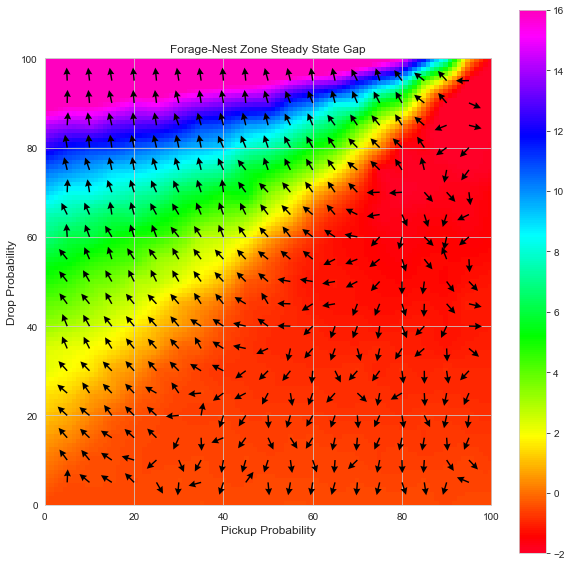

In [9]:
"""
plots heatmap landscapes using population zone data gathered in the ABM notebook file
- Forage Zone / Tree Zone / Nest Zone signify the three main areas of the simulation space
    - Forage/Tree zones are divided by the dropping cells the the top of the tree
    - Tree/Nest zones are divided by the cache (where the leaves drop to) at the bottom
- 'Steady State' is the average ant population in a zone from ss_run_num to the end of the run
- 'Forage-Nest Zone Gap' is the differene between the ant populations in the two zones,
reflecting the balance between the top populations with respect to trait combination
"""

title = 'landscape_data_dplen10_ant25_spacing5_rep10_step1K'
master_data = pickle.load(open(title,'rb'))

plot_max = 18
ss_step_num = 500

data = pull_data_ss(master_data,7,ss_step_num)
max_min = find_max_min(data, print_max=True, print_min=True)
interp_data = interpolate(data, 'linear')
gradient_arrow_heatmap(interp_data, max_min=0, title=f'Forage Zone Steady State', 
    z_max=plot_max, normalize=True, vanishing_arrows=True, arrow_size=.5)

data = pull_data_ss(master_data,8,ss_step_num)
max_min = find_max_min(data, print_max=True, print_min=True)
interp_data = interpolate(data, 'linear')
gradient_arrow_heatmap(interp_data, max_min=0, title=f'Tree Zone Steady State',
    z_max=plot_max, normalize=True, vanishing_arrows=True, arrow_size=.5)

data = pull_data_ss(master_data,6,ss_step_num)
max_min = find_max_min(data, print_max=True, print_min=True)
interp_data = interpolate(data, 'linear')
gradient_arrow_heatmap(interp_data, max_min=0, title=f'Nest Zone Steady State', 
    z_max=plot_max, normalize=True, vanishing_arrows=True, arrow_size=.5)

data = pull_data_ss_foragenest_gap(master_data,ss_step_num)
max_min = find_max_min(data, print_max=True, print_min=True)
interp_data = interpolate(data, 'linear')
gradient_arrow_heatmap(interp_data, max_min=0, title=f'Forage-Nest Zone Steady State Gap',
    z_min=-2, z_max=plot_max-2, normalize=True, vanishing_arrows=True, arrow_size=.5)

# Comparing Population Zone Landscapes

pp_max: 0, dp_max: 100, z_max: 22.8
pp_min: 90, dp_min: 90, z_min: -2.2


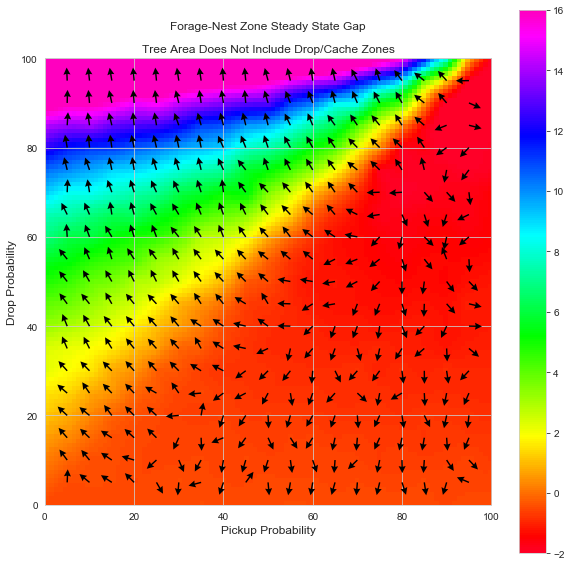

pp_max: 5, dp_max: 100, z_max: 18.9
pp_min: 100, dp_min: 100, z_min: -0.5


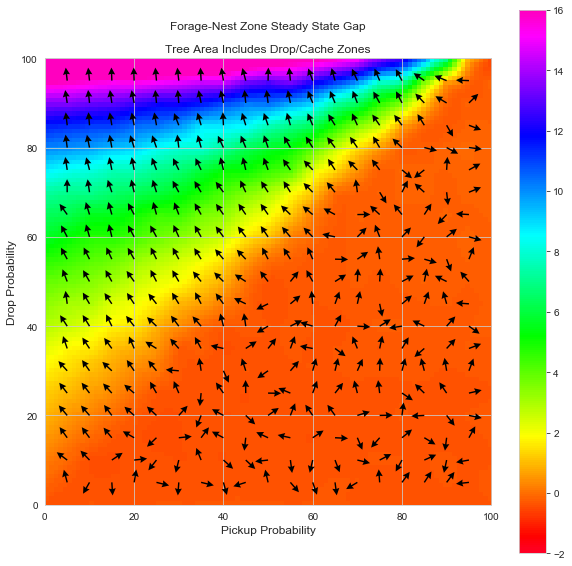

In [10]:
"""
comparing two methods of zone_count()
- tree area does not include drop/cache zones
    - high pp where pp > dp shows an extra ~2 ants in the nest zone relative to the foraging zone
    - area coincides with the greatest total score
- tree area includes drop/cache zones
    - when pp > dp, ants in the nest/foraging zone are equal
    
thus, the extra ~2 ants are located at the cache zone, showing that in order to maximize fitness,
there needs to be more collectors relative to foragers to make up for the inefficiency of 
searching for dropped leaves at the base of the tree
"""

title_excltree = 'landscape_data_dplen10_ant25_spacing5_rep10_step1K'
title_incltree = 'landscape_data_dplen10_ant25_spacing5_rep10_step1K_incltree'

master_data_excltree = pickle.load(open(title_excltree,'rb'))
master_data_incltree = pickle.load(open(title_incltree,'rb'))

plot_max = 18
ss_step_num = 500

data = pull_data_ss_foragenest_gap(master_data_excltree,ss_step_num)
max_min = find_max_min(data, print_max=True, print_min=True)
interp_data = interpolate(data, 'linear')
gradient_arrow_heatmap(interp_data, max_min=0, 
    title=f'Forage-Nest Zone Steady State Gap\n\nTree Area Does Not Include Drop/Cache Zones',
    z_min=-2, z_max=plot_max-2, normalize=True, vanishing_arrows=True, arrow_size=.5)

data = pull_data_ss_foragenest_gap(master_data_incltree,ss_step_num)
max_min = find_max_min(data, print_max=True, print_min=True)
interp_data = interpolate(data, 'linear')
gradient_arrow_heatmap(interp_data, max_min=0, 
    title=f'Forage-Nest Zone Steady State Gap\n\nTree Area Includes Drop/Cache Zones',
    z_min=-2, z_max=plot_max-2, normalize=True, vanishing_arrows=True, arrow_size=.5)

In [11]:
def compare(dataA,dataB):
    """
    compares two landscape heatmaps by taking difference between z values
    """
    subtracted_z_variable = [A-B for A,B in zip(dataA[2],dataB[2])]
    return dataA[0], dataA[1], subtracted_z_variable

pp_max: 30, dp_max: 100, z_max: 4.1
pp_min: 80, dp_min: 70, z_min: 1.0


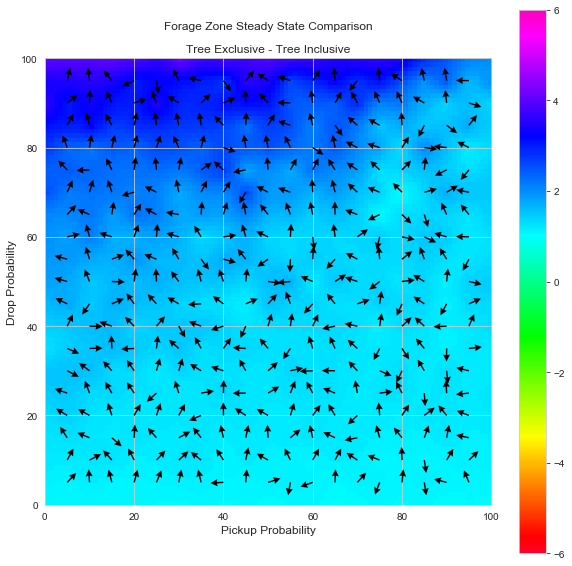

pp_max: 80, dp_max: 0, z_max: -2.3
pp_min: 100, dp_min: 95, z_min: -5.8


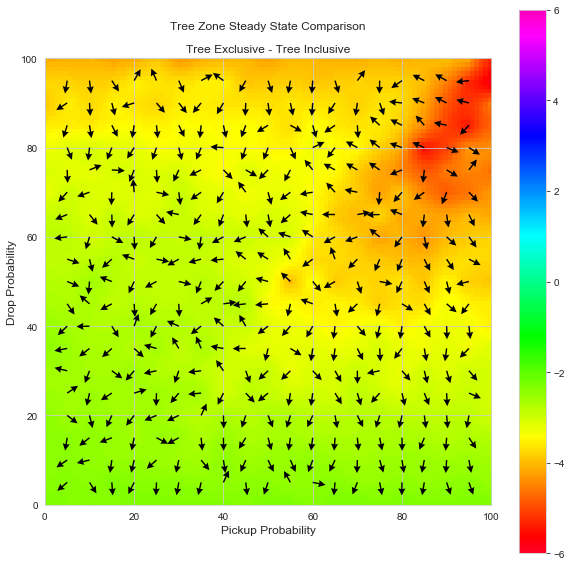

pp_max: 100, dp_max: 95, z_max: 3.8
pp_min: 10, dp_min: 100, z_min: 0.1


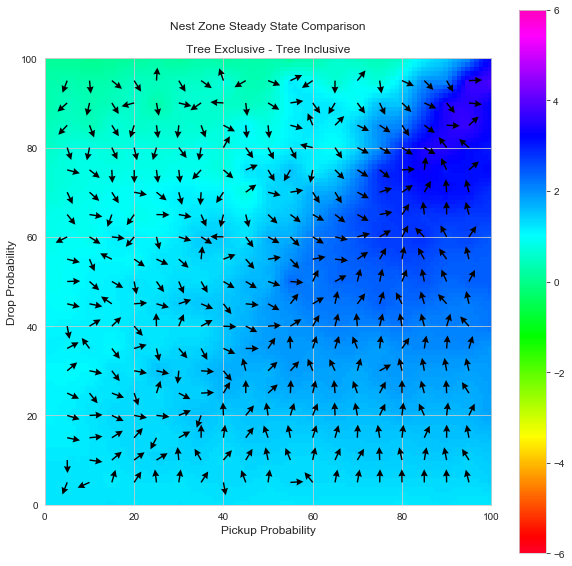

pp_max: 30, dp_max: 100, z_max: 4.0
pp_min: 90, dp_min: 90, z_min: -2.1


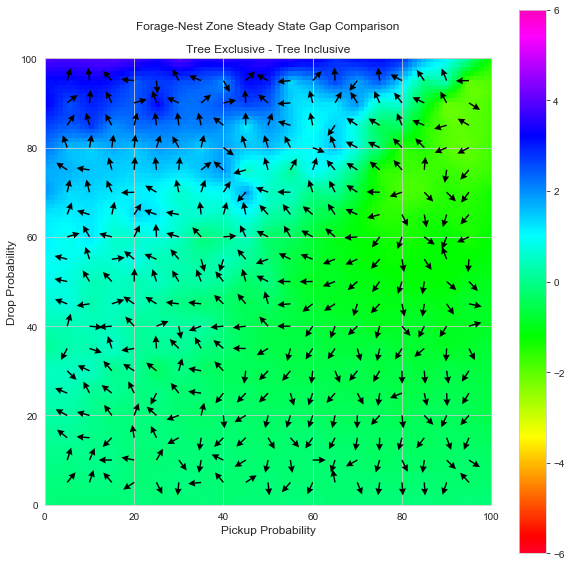

In [12]:
ss_step_num = 500
z_min = -6
z_max = 6

title_excltree = 'landscape_data_dplen10_ant25_spacing5_rep10_step1K'
title_incltree = 'landscape_data_dplen10_ant25_spacing5_rep10_step1K_incltree'

master_data_excltree = pickle.load(open(title_excltree,'rb'))
master_data_incltree = pickle.load(open(title_incltree,'rb'))

data_excltree = pull_data_ss(master_data_excltree,7,ss_step_num)
data_incltree = pull_data_ss(master_data_incltree,7,ss_step_num)
data = compare(data_excltree,data_incltree)
max_min = find_max_min(data, print_max=True, print_min=True)
interp_data = interpolate(data, 'linear')
gradient_arrow_heatmap(interp_data, max_min=0, 
    title=f'Forage Zone Steady State Comparison\n\nTree Exclusive - Tree Inclusive',
    z_min=z_min, z_max=z_max, normalize=True, vanishing_arrows=True, arrow_size=.5)

data_excltree = pull_data_ss(master_data_excltree,8,ss_step_num)
data_incltree = pull_data_ss(master_data_incltree,8,ss_step_num)
data = compare(data_excltree,data_incltree)
max_min = find_max_min(data, print_max=True, print_min=True)
interp_data = interpolate(data, 'linear')
gradient_arrow_heatmap(interp_data, max_min=0, 
    title=f'Tree Zone Steady State Comparison\n\nTree Exclusive - Tree Inclusive',
    z_min=z_min, z_max=z_max, normalize=True, vanishing_arrows=True, arrow_size=.5)

data_excltree = pull_data_ss(master_data_excltree,6,ss_step_num)
data_incltree = pull_data_ss(master_data_incltree,6,ss_step_num)
data = compare(data_excltree,data_incltree)
max_min = find_max_min(data, print_max=True, print_min=True)
interp_data = interpolate(data, 'linear')
gradient_arrow_heatmap(interp_data, max_min=0, 
    title=f'Nest Zone Steady State Comparison\n\nTree Exclusive - Tree Inclusive',
    z_min=z_min, z_max=z_max, normalize=True, vanishing_arrows=True, arrow_size=.5)

data_excltree = pull_data_ss_foragenest_gap(master_data_excltree,ss_step_num)
data_incltree = pull_data_ss_foragenest_gap(master_data_incltree,ss_step_num)
data = compare(data_excltree,data_incltree)
max_min = find_max_min(data, print_max=True, print_min=True)
interp_data = interpolate(data, 'linear')
gradient_arrow_heatmap(interp_data, max_min=0, 
    title=f'Forage-Nest Zone Steady State Gap Comparison\n\nTree Exclusive - Tree Inclusive',
    z_min=z_min, z_max=z_max, normalize=True, vanishing_arrows=True, arrow_size=.5)